## Image Classification Model Using AlexNet

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:

transform = transforms.Compose([
    transforms.Resize((227, 227)), #Alexnet expects an input size of 227 x 227 x 3
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

In [4]:
train_data_path = r'/Users/azeez/Desktop/AI/Personal Projects/GitHub/Computer-Vision-using-PyTorch/Human Action Recognition/train'
test_data_path = r'/Users/azeez/Desktop/AI/Personal Projects/GitHub/Computer-Vision-using-PyTorch/Human Action Recognition/test'

In [5]:
train_data = datasets.ImageFolder(root=train_data_path, transform=transform)
test_data = datasets.ImageFolder(root=test_data_path, transform=transform)

### AlexNet Architecture

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=5):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # Calculate the size of the feature map after the last pooling layer
        self.fc_input_dim = 256 * 6 * 6  # This is for input size 224x224

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(self.fc_input_dim, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

In [8]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
device 

device(type='cpu')

In [11]:
# Initialize the model
model = AlexNet().to(device)

In [12]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [13]:
# Create DataLoader for training and validation sets
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [14]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize the lists to store train and test loss for each epoch
train_losses = []
test_losses = []

# Train the model
num_epochs = 20
best_loss = torch.inf
patience = 5
epochs_since_best = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # For models that return auxiliary outputs
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)  # Store the train loss for this epoch
    train_accuracy = 100. * correct / total

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # For models that return auxiliary outputs
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)  # Store the test loss for this epoch
    test_accuracy = 100. * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Check for best accuracy and stop if not improved after five more epochs
    if test_loss < best_loss:
        best_loss = test_loss
        epochs_since_best = 0
        torch.save(model.state_dict(), 'best_model_AlexNet.pth')  # Save the model
        print(f'Updated best model with accuracy: {test_accuracy:.2f}%')
    else:
        epochs_since_best += 1
        if epochs_since_best > patience:
            print("Stopping early: no improvement after five consecutive epochs.")
            break

100%|██████████| 112/112 [01:30<00:00,  1.24it/s]


Epoch [1/20], Train Loss: 1.6205, Train Accuracy: 21.15%
Test Loss: 1.5733, Test Accuracy: 24.44%
Updated best model with accuracy: 24.44%


100%|██████████| 112/112 [01:29<00:00,  1.25it/s]


Epoch [2/20], Train Loss: 1.5831, Train Accuracy: 24.93%
Test Loss: 1.5567, Test Accuracy: 23.65%
Updated best model with accuracy: 23.65%


100%|██████████| 112/112 [01:30<00:00,  1.23it/s]


Epoch [3/20], Train Loss: 1.5767, Train Accuracy: 24.76%
Test Loss: 1.5526, Test Accuracy: 28.57%
Updated best model with accuracy: 28.57%


100%|██████████| 112/112 [01:33<00:00,  1.19it/s]


Epoch [4/20], Train Loss: 1.5584, Train Accuracy: 28.85%
Test Loss: 1.5683, Test Accuracy: 25.56%


100%|██████████| 112/112 [01:32<00:00,  1.21it/s]


Epoch [5/20], Train Loss: 1.5454, Train Accuracy: 29.52%
Test Loss: 1.5166, Test Accuracy: 34.92%
Updated best model with accuracy: 34.92%


100%|██████████| 112/112 [01:36<00:00,  1.16it/s]


Epoch [6/20], Train Loss: 1.5223, Train Accuracy: 31.76%
Test Loss: 1.5536, Test Accuracy: 29.84%


100%|██████████| 112/112 [01:39<00:00,  1.13it/s]


Epoch [7/20], Train Loss: 1.4994, Train Accuracy: 33.59%
Test Loss: 1.4425, Test Accuracy: 40.95%
Updated best model with accuracy: 40.95%


100%|██████████| 112/112 [01:38<00:00,  1.14it/s]


Epoch [8/20], Train Loss: 1.4893, Train Accuracy: 33.78%
Test Loss: 1.4288, Test Accuracy: 40.32%
Updated best model with accuracy: 40.32%


100%|██████████| 112/112 [01:40<00:00,  1.12it/s]


Epoch [9/20], Train Loss: 1.4495, Train Accuracy: 37.62%
Test Loss: 1.3885, Test Accuracy: 38.89%
Updated best model with accuracy: 38.89%


100%|██████████| 112/112 [01:43<00:00,  1.08it/s]


Epoch [10/20], Train Loss: 1.4271, Train Accuracy: 38.01%
Test Loss: 1.4200, Test Accuracy: 38.41%


100%|██████████| 112/112 [01:43<00:00,  1.08it/s]


Epoch [11/20], Train Loss: 1.4135, Train Accuracy: 39.66%
Test Loss: 1.3817, Test Accuracy: 41.90%
Updated best model with accuracy: 41.90%


100%|██████████| 112/112 [01:37<00:00,  1.15it/s]


Epoch [12/20], Train Loss: 1.4068, Train Accuracy: 41.04%
Test Loss: 1.3893, Test Accuracy: 39.68%


100%|██████████| 112/112 [01:36<00:00,  1.16it/s]


Epoch [13/20], Train Loss: 1.3461, Train Accuracy: 43.47%
Test Loss: 1.3037, Test Accuracy: 45.71%
Updated best model with accuracy: 45.71%


100%|██████████| 112/112 [01:48<00:00,  1.04it/s]


Epoch [14/20], Train Loss: 1.3320, Train Accuracy: 43.75%
Test Loss: 1.3171, Test Accuracy: 44.92%


100%|██████████| 112/112 [01:43<00:00,  1.08it/s]


Epoch [15/20], Train Loss: 1.3006, Train Accuracy: 46.67%
Test Loss: 1.3555, Test Accuracy: 41.90%


100%|██████████| 112/112 [01:45<00:00,  1.06it/s]


Epoch [16/20], Train Loss: 1.2826, Train Accuracy: 47.03%
Test Loss: 1.2500, Test Accuracy: 48.41%
Updated best model with accuracy: 48.41%


100%|██████████| 112/112 [01:41<00:00,  1.10it/s]


Epoch [17/20], Train Loss: 1.2325, Train Accuracy: 49.80%
Test Loss: 1.2573, Test Accuracy: 50.63%


100%|██████████| 112/112 [01:44<00:00,  1.07it/s]


Epoch [18/20], Train Loss: 1.2199, Train Accuracy: 49.66%
Test Loss: 1.2138, Test Accuracy: 53.17%
Updated best model with accuracy: 53.17%


100%|██████████| 112/112 [01:39<00:00,  1.13it/s]


Epoch [19/20], Train Loss: 1.1618, Train Accuracy: 53.36%
Test Loss: 1.2613, Test Accuracy: 47.30%


100%|██████████| 112/112 [01:48<00:00,  1.03it/s]


Epoch [20/20], Train Loss: 1.1541, Train Accuracy: 53.53%
Test Loss: 1.2381, Test Accuracy: 49.37%


### Plot: Epochs vs Train Loss and Test

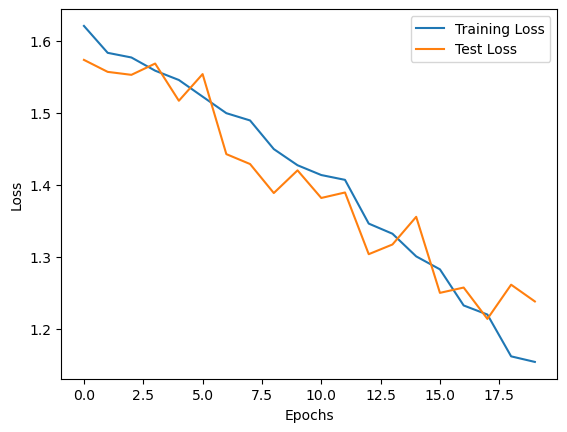

In [16]:
# Plotting the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()